# Laboratorium 3 - Czy sieci neuronowe śnią o ciastach marchewkowych?

## _Jakub Szaredko_

In [1]:
import os
from datetime import datetime

import IPython.display as d

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
import torchvision.transforms.v2 as transforms
import torchvision.transforms.v2.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import matplotlib.pyplot as plt

GENERATOR_INPUT_SIZE = 64
BATCH_SIZE = 32


def normalize_image(image: torch.Tensor) -> torch.Tensor:
    return (image - image.min()) / (image.max() - image.min())


def display(
    *images: torch.Tensor,
    resize_scale: tuple[float, float] | None = None
) -> None:
    if (len(images) == 0):
        return

    pil_images: list[Image.Image] \
        = [F.to_pil_image(image) for image in images]

    if resize_scale is not None:
        sw, sh = resize_scale
        for i, image in enumerate(pil_images):
            w, h = image.size
            size: tuple[int, int] = int(sw * w), int(sh * h)
            pil_images[i] = image.resize(size, Image.Resampling.NEAREST)

    d.display(*pil_images)


def show_samples(images: torch.Tensor) -> None:
    sample_count: int = images.size(dim=0)

    _, axes = plt.subplots(1, sample_count, figsize=(15, 5))
    for i in range(sample_count):
        image = images[i].permute(1, 2, 0).numpy()
        axes[i].imshow(image)
        axes[i].axis("off")

    plt.show()

## Architektura dyskryminatora

Architektura dyskryminatora to dokładnie taka sama architektura jak z zadania
zamodelowana we frameworku PyTorch. Posiada 3 warstwy konwolucyjne, w która
każda korzysta z `BatchNorm` oraz funkcji aktywacji `LeakyReLU`. Moduły
konwolucyjne nie mają bezpośrednio zdefiniowanego paddingu typu same, natomiast
takowy posiadają. W końcowej fazie architektury wygenerowane tensory
są spłaszczane, dodany jest do wektora `Dropout` o $p = 0.2$., tworzona jest
warstwa gęsta i na koniec wyjście jest przetwarzane przez funkcję sigmoidalną.

In [2]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(64 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

## Architektura generatora

Architektura generatora to takzę dokładnie taka sama architektura jak z zadania
zamodelowana we frameworku PyTorch. Na wejściu posiada warstwę gęsto połączoną,
następnie zamienia płaski wektor na tensor o rozmiarach $64 \times 4 \times 4$.
Posiada 3 warstwy transponowano-konwolucyjne, w która każda korzysta funkcji
aktywacji `LeakyReLU`. W końcowej fazie architektury wygenerowane tensory
są konwertowane do trzech kanałów, które będą definiować przestrzeń RGB za pomocą
warstwy konwolucyjnej, na sam koniec wygenerowany obraz jest normalizowany
za pomocą funkcji tangensa hiperbolicznego `Tanh`.

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model: nn.Sequential = nn.Sequential(
            nn.Linear(GENERATOR_INPUT_SIZE, GENERATOR_INPUT_SIZE * 4 * 4),
            nn.Unflatten(dim=1, unflattened_size=(64, 4, 4)),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(256, 3, kernel_size=5, stride=1, padding=2),
            nn.Tanh()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)


### Przykładowy wygenerowany obraz

Wygenerowane zdjęcie przez niewytrenowany model to zbiór pikseli w ścisłej
okolicy zera. Obrazek został znormalizowany, aby piksel najciemniejszy
i najaśniejszy reprezentował odpowiednio wartość $0.0$ i $1.0$.

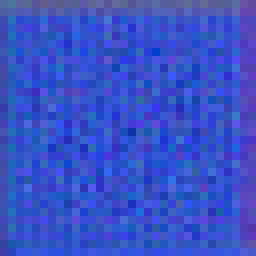

In [4]:
generator: Generator = Generator()

noise = torch.randn(1, GENERATOR_INPUT_SIZE)
generator.eval()
with torch.no_grad():
    generated_image: torch.Tensor = generator(noise).squeeze()
generated_image = (generated_image + 1.0) / 2.0

display(normalize_image(generated_image), resize_scale=(8.0, 8.0))

## Przygotowanie zbioru danych treningowych

Głównym zbiorem tego laboratorium są prawdziwe obrazy ciast marchewkowych
pobranych z internetu, które zostały dołączone do tego zadania
(`crawled_cakes`).

In [5]:
class CarrotCakeDataset(Dataset):
    def __init__(
        self,
        image_dir: str,
        transform: transforms.Transform | None = None
    ):
        self.image_dir: str = image_dir
        self.image_files: list[str] = os.listdir(image_dir)
        self.transform: transforms.Transform | None = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx: int) -> torch.Tensor:
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image

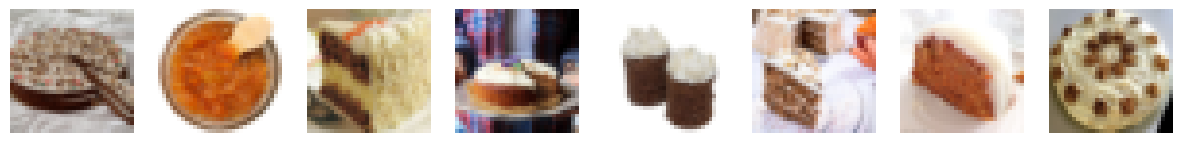

In [6]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset_path = "./dataset/crawled-cakes"

dataset = CarrotCakeDataset(dataset_path, transform=transform)
data_loader = DataLoader(dataset, BATCH_SIZE, shuffle=True)

show_samples(next(iter(data_loader))[:8] * 0.5 + 0.5)

## Proces trenowania

### Trening przed treningiem

Implementacja treningu pojedynczej warstwy architektury przebiegła bez
komplikacji. Architektura to 2 warstwy pełni połączone, składające się tylko
z 3 neuronów, funkcja kosztu to średnia wartości wyniku odjęta o $42$. W każdej
iteracji koszt się zmniejszał bardzo delikatnie.

In [7]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [8]:
simple_model = SimpleModel()

input_data = torch.randn((9, 3), requires_grad=True)
output = simple_model(input_data)
fake_loss_d = output.mean() - 42

simple_model.fc1.weight.retain_grad()
fake_loss_d.backward(retain_graph=True)

optimizer = optim.SGD([simple_model.fc1.weight, simple_model.fc1.bias], lr=0.01)

for i in range(5):
    optimizer.zero_grad()
    output = simple_model(input_data)
    fake_loss_d = output.mean() - 42

    fake_loss_d.backward(retain_graph=True)
    optimizer.step()

    print(f"Epoch {i + 1}, loss: {fake_loss_d.item()}")

Epoch 1, loss: -42.08427810668945
Epoch 2, loss: -42.087642669677734
Epoch 3, loss: -42.091007232666016
Epoch 4, loss: -42.09437561035156
Epoch 5, loss: -42.097740173339844


### Właściwy proces

Przed nami ciekawa, a zarazem nudna część tego laboratorium — czyli trening 🙂
Trening składał się z 3000 epok, postęp był zapisywany i monitorowany co każde
50 epok. Był to dla mnie absolutnie najcięższy i najbardziej czasochłonny etap,
który kosztował mnie bardzo dużo godzin, nie wspominając już o samym treningu,
który trwał lekko ponad 3 godziny na GPU Apple M1 Pro. Zasadniczo były
2 problemy, na które napotkałem podczas tej części:

- trenowanie wygenerowanych zdjęć na dyskryminatorze zamiast na generatorze:
  w praktyce wiązało się to z wywołaniem metody `detach` na tensorze
  wygenerowanych obrazów przy wywołaniu dyskryminatora.
- brak normalizacji próbek w postaci przeskalowania do pełnej przestrzeni barw
  RGB (zakres $[0, 1]$), bez tego wyjście to były szare obrazki z losowymi
  ciemniejszymi lub jaśniejszymi plamkami w losowych miejscach.

W treningu dyskryminatora jest on wywoływany dwukrotnie z prawdziwymi oraz
fałszywymi obrazami oddzielnie.

In [9]:
def train_progress(
    epoch: int,
    epoch_count: int,
    noise_vectors: torch.Tensor,
    mean_loss_d: float,
    mean_loss_g: float,
    discriminator: Discriminator,
    generator: Generator,
    optimizer_d: optim.Optimizer,
    optimizer_g: optim.Optimizer
) -> None:
    def log(epoch: int, message: str) -> None:
        pretty_date: str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        print(f"{pretty_date} — Epoch [{epoch + 1}/{epoch_count}] — {message}")

    log(epoch, f"Discriminator Loss: {mean_loss_d:.4f}")
    log(epoch, f"Generator Loss: {mean_loss_g:.4f}")

    generator.eval()
    generated_images: torch.Tensor = generator(noise_vectors)

    show_samples(normalize_image(generated_images.detach().cpu()[:8]))
    save_image(
        generated_images,
        os.path.join("checkpoints/image", f"epoch_{epoch + 1}.png"),
        nrow=5,
        normalize=True
    )

    torch.save({
        "epoch": epoch,
        "generator_state_dict": generator.state_dict(),
        "discriminator_state_dict": discriminator.state_dict(),
        "optimizer_d_state_dict": optimizer_d.state_dict(),
        "optimizer_g_state_dict": optimizer_g.state_dict(),
        "noise_vectors": noise_vectors,
    }, os.path.join("checkpoints/torch", f"epoch_{epoch + 1}.pt"))

def train(
    discriminator: Discriminator,
    generator: Generator,
    data_loader: DataLoader,
    device: torch.device | None = None,
    epoch_count: int = 10,
    save_every_n_epochs: int = 50
) -> None:
    if device is None:
        device: torch.device = torch.device(
            "mps" if torch.backends.mps.is_built()
                else "cuda" if torch.backends.cuda.is_built()
                    else "cpu"
        )

    discriminator.to(device)
    generator.to(device)

    criterion: nn.BCELoss = nn.BCELoss()
    optimizer_d = optim.Adam(
        discriminator.parameters(), lr=1e-5, betas=(0.7, 0.999), weight_decay=1e-2
    )
    optimizer_g = optim.Adam(generator.parameters(), lr=1e-5, betas=(0.7, 0.999))

    base_noise_vectors: torch.Tensor = torch.randn(25, GENERATOR_INPUT_SIZE) \
        .to(device)

    def train_discriminator(
        real_images: torch.Tensor,
        fake_images: torch.Tensor,
        real_labels: torch.Tensor,
        fake_labels: torch.Tensor
    ) -> float:
        real_d_outputs = discriminator(real_images)
        real_loss_d = criterion(real_d_outputs, real_labels)

        fake_d_outputs = discriminator(fake_images.detach())
        fake_loss_d = criterion(fake_d_outputs, fake_labels)

        loss_d = (real_loss_d + fake_loss_d) / 2

        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()

        return loss_d.item()

    def train_generator(
        fake_images: torch.Tensor,
        real_labels: torch.Tensor
    ) -> float:
        g_outputs = discriminator(fake_images)
        loss_g = criterion(g_outputs, real_labels)

        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()

        return loss_g.item()

    for epoch in range(epoch_count):
        generator.train()
        discriminator.train()

        cumulative_loss_d: float = 0.0
        cumulative_loss_g: float = 0.0

        for real_images in data_loader:
            real_images = real_images.to(device)
            real_labels: torch.Tensor = torch.normal(
                1.0, 0.05, (real_images.size(dim=0), 1)
            ).to(device)

            noise = torch.randn(real_images.size(dim=0), GENERATOR_INPUT_SIZE) \
                .to(device)
            fake_images = generator(noise)
            fake_labels = torch.normal(
                0.0, 0.05, (real_images.size(dim=0), 1)
            ) \
                .to(device)

            cumulative_loss_d += train_discriminator(
                real_images, fake_images, real_labels, fake_labels
            )
            cumulative_loss_g += train_generator(fake_images, real_labels)

        mean_loss_d: float = cumulative_loss_d / len(data_loader)
        mean_loss_g: float = cumulative_loss_g / len(data_loader)

        if (epoch + 1) % save_every_n_epochs == 0 or epoch == 0:
            train_progress(
                epoch,
                epoch_count,
                base_noise_vectors,
                mean_loss_d,
                mean_loss_g,
                discriminator,
                generator,
                optimizer_d,
                optimizer_g
            )

In [10]:
device: torch.device = torch.device(
    "mps" if torch.backends.mps.is_built()
        else "cuda" if torch.backends.cuda.is_built()
            else "cpu"
)

discriminator: Discriminator = Discriminator()
generator: Generator = Generator()

if 21 == 37:
    train(
        discriminator,
        generator,
        data_loader,
        device,
        epoch_count=3000,
        save_every_n_epochs=50
    )

Poniżej dołączam po 8 wygenerowanych obrazów z kilku epok wraz z kosztami
dyskryminatora i generatora.

- ```
  2024-11-10 17:34:58 — Epoch [1/3000] — Discriminator Loss: 0.7797
  2024-11-10 17:34:58 — Epoch [1/3000] — Generator Loss: 0.6414
  ```

  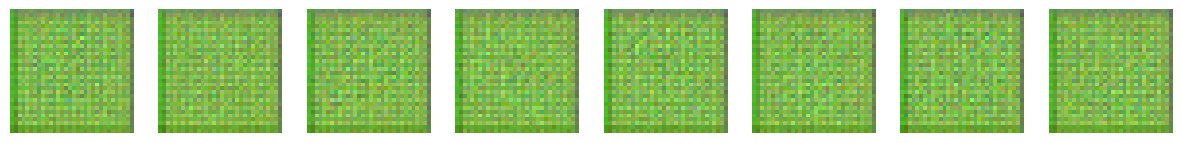

- ```
  2024-11-10 17:56:49 — Epoch [350/3000] — Discriminator Loss: 0.5965
  2024-11-10 17:56:49 — Epoch [350/3000] — Generator Loss: 0.8447
  ```

  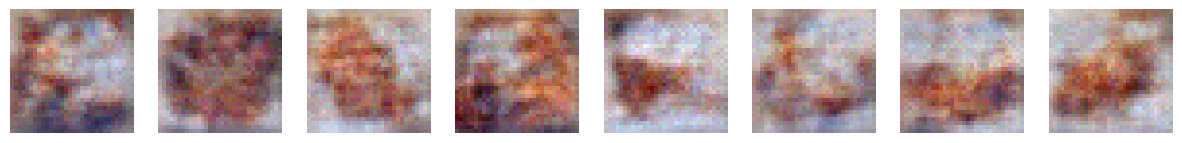

- ```
  2024-11-10 19:09:19 — Epoch [1500/3000] — Discriminator Loss: 0.2662
  2024-11-10 19:09:19 — Epoch [1500/3000] — Generator Loss: 1.7126
  ```

  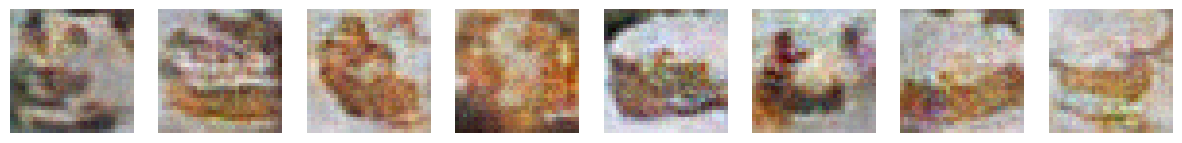

- ```
  2024-11-10 19:41:57 — Epoch [2000/3000] — Discriminator Loss: 0.1799
  2024-11-10 19:41:57 — Epoch [2000/3000] — Generator Loss: 2.2183
  ```
  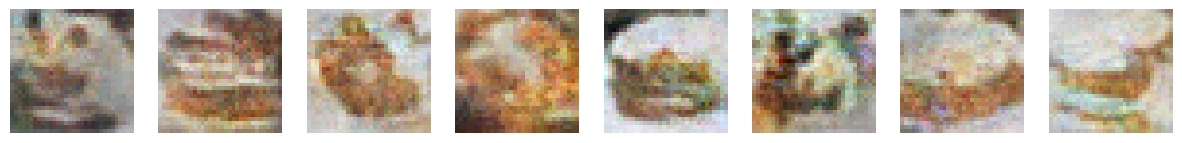

- ```
  2024-11-10 20:45:30 — Epoch [3000/3000] — Discriminator Loss: 0.1020
  2024-11-10 20:45:30 — Epoch [3000/3000] — Generator Loss: 2.7723
  ```

  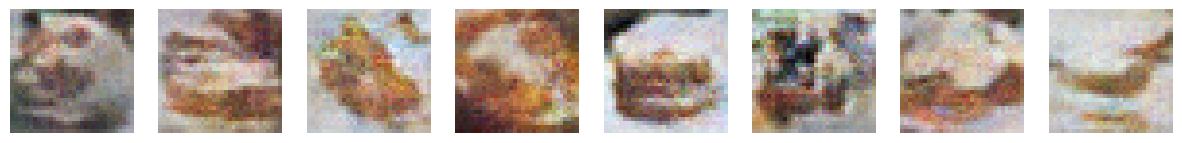

Jak widać już w 350. epoce zdjęcia już przypominały ciasta marchewkowe (takie
z 1970 roku 😝), pomiędzy 1500. a 3000. nie było znaczących zmian, model widać,
że w tej fazie uczył się detali obrazów, które wpływają na jego wiarygodność.
Ostatecznie generowane obrazy przez model są przeciętnie przyzwoite, ale i tak
cieszył widok coraz lepszej generacji z każdą następną epoką. Nie mam
pewności czy większość ludzi nabrałaby się na sztuczki mojego generatora.

## Wykorzystanie wytrenowanego generatora

Za najpewniejszy model wybrałem ten z ostatniej epoki (czyli 3000.), natomiast
do treningu szumu wybrałem równe 1000 kroków.

W mojej wersji akceptowalne wyniki dopiero generowały się po kilku tysiącach
kroków, bardzo mocno jest to oczywiście uzależnione od wygenerowanego bazowego
szumu oraz wybranego zdjęcia do odwzorowania. Mogę z pewnością rzecz,
że wytrenowany model radzi sobie jak tło jest jasne i zawiera akcenty koloru
marchewkowego. W innym przypadku jakość generacji ulega zauważalnej degradacji,
jeśli liczba kroków jest za mała.

Ręczna zmiana kilku składowych wektora szumu wpływa zauważalnie na jego
generację, u mnie obrazy zmieniały lokalnie barwę na bardziej żywe kolory,
jest to dość dobra metoda do generowania jakiś abstrakcyjnych grafik 😆

In [11]:
device: torch.device = torch.device(
    "mps" if torch.backends.mps.is_built()
        else "cuda" if torch.backends.cuda.is_built()
            else "cpu"
)

checkpoint = torch.load("checkpoints/torch/epoch_3000.pt", weights_only=True)
generator: Generator = Generator()
generator.load_state_dict(checkpoint["generator_state_dict"])

<All keys matched successfully>

In [12]:
def reproduce_image(
    generator: Generator,
    target_image: torch.Tensor,
    step_count: int = 1000,
    generation_progress_frame_count: int = 8
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    noise: torch.Tensor = torch.randn(
        1, GENERATOR_INPUT_SIZE, requires_grad=True
    )
    initial_noise: torch.Tensor = noise.detach().clone()

    criterion = nn.MSELoss()
    optimizer = optim.SGD([noise], lr=0.01, momentum=0.9)

    save_progress_every: int \
        = step_count // (generation_progress_frame_count - 2)
    generated_image: torch.Tensor = torch.FloatTensor()
    generated_images: list[torch.Tensor] = []

    for step in range(step_count):
        generator.eval()
        generated_image = generator(noise)[0]

        if step % save_progress_every == 0 or step == step_count - 1:
            generated_images.append(generated_image)

        optimizer.zero_grad()

        loss = criterion(generated_image, target_image)
        loss.backward()

        optimizer.step()

    return (
        generated_image,
        noise,
        initial_noise,
        normalize_image(torch.stack(generated_images).detach().cpu()),
    )


def lets_reproduce_image(
    image_path: str,
    generator: Generator,
    change_noise=False,
    interpolate=False
) -> None:
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    image = transform(image)

    display(image.squeeze(dim=0) * 0.5 + 0.5, resize_scale=(8.0, 8.0))

    generated_image, noise, initial_noise, generated_images \
        = reproduce_image(generator, image)

    if interpolate:
        interpolated_noise_vectors = [
            torch.lerp(initial_noise, noise, t) for t in torch.linspace(0, 1, 8)
        ]
        generated_images = normalize_image(torch.stack([
            generator(noise)[0].detach().cpu()
            for noise in interpolated_noise_vectors
        ]))

    show_samples(generated_images)

    if change_noise:
        noise = noise.detach()
        noise[0][0] = 1.5
        noise[0][1] = 2.5
        noise[0][5] = 0.0
        noise[0][8] = -1.1

        generated_image = generator(noise)[0]

        display(generated_image, resize_scale=(8.0, 8.0))

### Odtworzenie obrazów ze zbioru treningowego

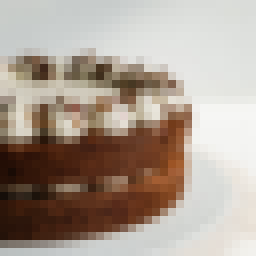

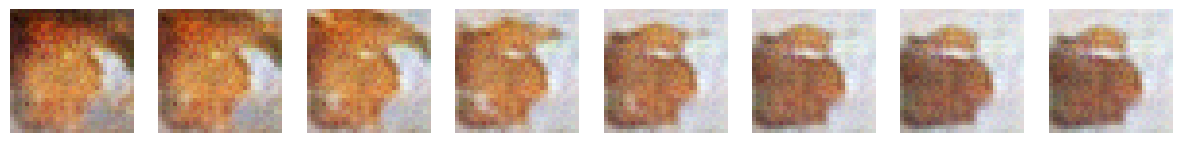

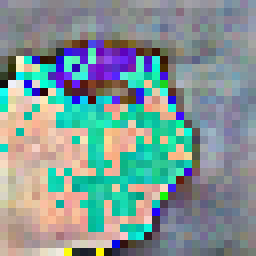

In [13]:
lets_reproduce_image(
    "dataset/crawled-cakes/156_7fba2edd.jpg", generator, change_noise=True
)

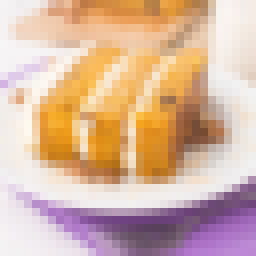

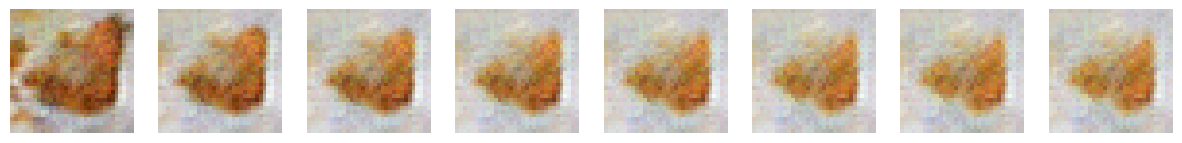

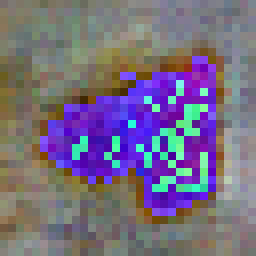

In [14]:
lets_reproduce_image(
    "dataset/crawled-cakes/053_2634e440.jpg", generator, change_noise=True
)

### Odtworzenie obrazu z zupełnie innej przestrzeni

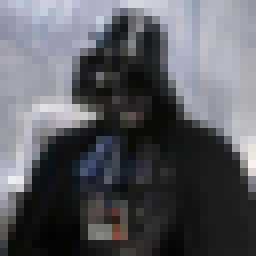

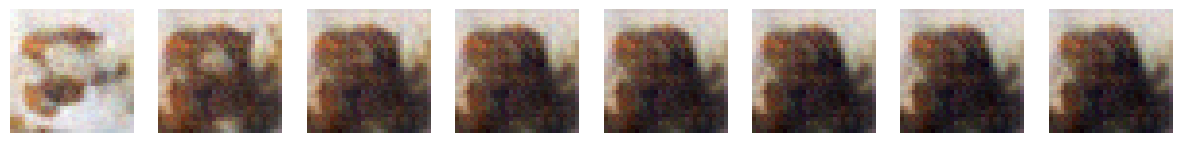

In [15]:
lets_reproduce_image(
    "dataset/star-wars/darth-vader.jpg", generator, interpolate=False
)

### Odtworzenie obrazu ze zbioru treningowego z wykorzystaniem interpolacji

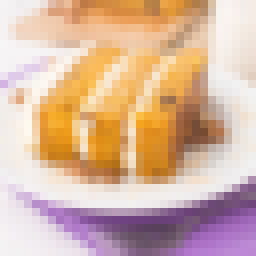

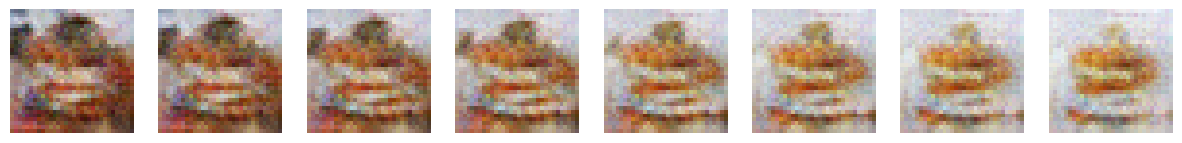

In [16]:
lets_reproduce_image(
    "dataset/crawled-cakes/053_2634e440.jpg", generator, interpolate=True
)

Jak można było się spodziwać, model ma trudności z generowaniem typów obrazów
spoza zbioru treningowego. Wygenerowany Darth Vader ewidentnie przed zdjęciem
wpadł do szybu z ciastem marchewkowym niczym Darth Sidious lub worek ziemniaków
rzucony przez Mariusza Pudzianowskiego.

## Podsumowanie

To laboratorium było na pewno najciekawszym do tej pory, ale jednocześnie
najbardziej frustrującym i czasochłonnym (jedno wynika z drugiego). Mimo
napotkanych problemów czuję olbrzymią ulgę — może przez to, że to już koniec,
a może przez to, że odczuwałem dziecinną satysfakcję, bawiąc się wytrenowanym
generatorem, a może to połączenie obu lub czegoś jeszcze innego, kto wie 😉